In [1]:
%load_ext autoreload
%autoreload 2

import os 
# Set the environment for R
# os.environ['R_HOME']= r'C:\Users\tomha\miniconda3\envs\octagon_analysis\lib\R'
# os.environ['R_HOME']=r'D:\Users\Tom\miniconda3\envs\octagon_analysis\lib\R'
os.environ['R_HOME']= '/home/tom/miniconda3/envs/octagon_analysis/lib/R'


import rpy2.robjects as robjects
from rpy2.robjects.packages import importr

print(robjects.r('R.version.string'))

import parse_data.prepare_data as prepare_data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import globals
import data_strings
import data_extraction.get_indices as get_indices
import analysis.wall_visibility_and_choice as wall_visibility_and_choice
from trajectory_analysis import trajectory_vectors
from plotting import plot_octagon
import parse_data.identify_filepaths as identify_filepaths 
from analysis import opponent_visibility
import pickle


[1] "R version 4.3.3 (2024-02-29)"



# GLM model generation notebook (not cross-validated, see glm_model_comparsions and glm_analysis)

In [2]:
# load analysis_results dictionary or create it
load_analysis_results = True

### Load data and combine solo sessions (pre- and post-)

In [ ]:
data_folder = data_strings.DATA_FOLDER
json_filenames_social, json_filenames_solo = identify_filepaths.get_filenames()

In [38]:
# # restrict data for testing
# json_filenames_social = json_filenames_social[:8]
# json_filenames_solo = json_filenames_solo[:32]

In [ ]:
df, trial_lists_social = prepare_data.prepare_data(data_folder, json_filenames_social, combine=False)

In [ ]:
df, trial_lists_solo = prepare_data.prepare_data(data_folder, json_filenames_solo, combine=False)

In [40]:
# create a list of combined pre- and post- social solo sessions, removing 5 trials from each pre
trial_lists_combined_solo = []
cut_trials = 5
for i in range(0,len(trial_lists_solo), 2): # iterate over each individual
    # get the trial lists for both solo sessions
    trial_list_first_solo = trial_lists_solo[i]
    trial_list_second_solo = trial_lists_solo[i + 1]

    # cut first cut_trials trials (learning controls/associations) from the first solo
    trial_list_first_solo = trial_list_first_solo[cut_trials:]

    # combine trial lists from the first and second solo sessions (the current and consecutive index)
    trial_list = trial_list_first_solo + trial_list_second_solo

    trial_lists_combined_solo.append(trial_list)


In [41]:
len(trial_lists_combined_solo), len(trial_lists_social)

(80, 40)

### Regressor value extraction functions (for one session). To be used if not loading pre-generated analysis_results

In [2]:
def extract_wall_sep(trial_list, normalise=False):
    ''' Return wall separation for one session.
        1 for 45 degrees, 2 for 90 and 4 for 180. '''
    
    wall_sep = np.full(len(trial_list), np.nan)
    for i, trial in enumerate(trial_list):
        wall_sep_this_trial = get_indices.get_wall_difference(trial=trial)
        wall_sep[i] = wall_sep_this_trial

    if normalise:
        wall_sep = wall_sep/4

    return wall_sep


def extract_first_wall_seen(trial_list, player_id):
    ''' Return first visible walls for one player across one session.
        1 for WALL_1, 2 for WALL_2, np.nan for no visible wall (or both initially visible). '''
        
    high_wall_first_visible_session = wall_visibility_and_choice.get_given_wall_first_visible_session(trial_list,
                                                                                                        player_id,
                                                                                                        wall_index=0,
                                                                                                        current_fov=110)

    low_wall_first_visible_session = wall_visibility_and_choice.get_given_wall_first_visible_session(trial_list,
                                                                                                        player_id, 
                                                                                                        wall_index=1,
                                                                                                        current_fov=110)
    low_wall_first_visible_session = low_wall_first_visible_session*2
    
    first_visible_session = high_wall_first_visible_session + low_wall_first_visible_session

    first_visible_session[first_visible_session == 0] = np.nan

    return first_visible_session

def extract_first_wall_visibilities(trial_list, player_id, three_levels=False):
    ''' Return first visible walls for one player across one session.
        1 for WALL_1, 2 for WALL_2, and np.nan for no visible wall.
        If three_levels, 1 for WALL_1, 2 for WALL_2, 3 for both visible, and np.nan for neither. '''

    first_visible_session = np.full(len(trial_list), np.nan)
    for i, trial in enumerate(trial_list):
        wall_vis_order = wall_visibility_and_choice.get_wall_visibility_order_trial(player_id, trial, current_fov=110)

        # decide whether one wall is first visible, both were initially visible, or neither wall was visible
        # plus 1 to each index to match the wall number (1 and 2) rather than the index (0 and 1)
        if np.all(wall_vis_order == 0): # both walls visible at the start of the trial
            if three_levels:
                this_trial_first_visible = wall_vis_order.size + 1
            else:
                this_trial_first_visible = np.nan  # optionally set both walls visible to np.nan instead of 3
        elif np.all(np.isnan(wall_vis_order)): # neither wall visible at the start of the trial
            this_trial_first_visible = np.nan
        elif np.sum(wall_vis_order == 0) == 1: # one wall visible at the start of the trial
            this_trial_first_visible = np.where(wall_vis_order == 0)[0][0] + 1

        first_visible_session[i] = this_trial_first_visible

    return first_visible_session

# double check code
def extract_distances_to_walls(trial_list, player_id, normalise=False):
    ''' Return a trial_num, 2 sized array, where column 1
        is distance to WALL_1, and column 2 is distance to WALL_2.
        Data applies to one full session, and specified player_id.
        If normalise, returns distances as a proportion of the maximum
        possible in the arena '''
    
    # get octagon alcove coordinates
    alcove_coordinates = plot_octagon.return_alcove_centre_points()

    positions_session = np.full((len(trial_list), 2), np.nan)
    walls_session = np.full((len(trial_list), 2), np.nan)
    distances_session = np.full((len(trial_list), 2), np.nan)

    # get distances for each trial in the session
    for i, trial in enumerate(trial_list):
        # get WALL_1 and WALL_2 coordinates
        trial_walls = get_indices.get_walls(trial)
        high_wall_idx = trial_walls[0] - 1
        low_wall_idx = trial_walls[1] - 1
        trial_high_coordinates = alcove_coordinates[:,high_wall_idx]
        trial_low_coordinates = alcove_coordinates[:, low_wall_idx]

        # index trajectory at timepoint 0 to get player starting coordinates
        trajectory = trajectory_vectors.extract_trial_player_trajectory(trial=trial, player_id=player_id)
        trial_start_position = trajectory[:,0]

        # find distance between start position and WALL_1/WALL_2
        d2h = np.linalg.norm(trial_high_coordinates - trial_start_position) # WALL_1
        d2l = np.linalg.norm(trial_low_coordinates - trial_start_position) # WALL_2

        walls_session[i,:] = trial_walls 
        positions_session[i,:] = trial_start_position
        distances_session[i,:] = np.hstack((d2h, d2l))

    # normalise to maximum possible distance in octagon
    if normalise:
        distances_session = distances_session/plot_octagon.return_maximum_distance()

    return distances_session


def extract_opponent_visibility_slice_onset(trial_list, player_id, current_fov=110):
    ''' Return opponent visibility at slice onset for one player for one session.
        1 for opponent visible, 0 for opponent not visible '''
    
    # slice onset angle of Other from self centre FoV
    orientation_angle_to_other_session = opponent_visibility.get_angle_of_opponent_from_player_session(player_id, trial_list)

    # boolean array of Other visible
    other_visible_session = opponent_visibility.get_other_visible_session(orientation_angle_to_other_session, current_fov)
    other_visible_session = other_visible_session.astype(int) # converted to int for categorical regressor

    # does this return 1 and 0? 

    return other_visible_session


def extract_player_choice(trial_list, player_id, inferred_choice=True, debug=True):
    ''' Return (inferred by default) player choice for one player for one session.
        Where inferred and actual choice are both missing, values are np.nan '''

    # array of wall numbers where player choice is available, np.nan where it is not
    player_choice = wall_visibility_and_choice.get_player_wall_choice(trial_list, player_id,
                                                                        inferred_choice=inferred_choice, debug=debug)

    # 2 where player chose High, 0 where player chose Low, np.nan where lacking inferred choice
    high_wall_chosen_session = get_indices.was_given_wall_chosen(trial_list, player_choice,
                                                                    given_wall_index=0)
    high_wall_chosen_session = high_wall_chosen_session*2
    print(f"High wall chosen session:\n{high_wall_chosen_session}")

    # 1 where player chose Low, 0 where player chose High, np.nan where lacking inferred choice
    low_wall_chosen_session  = get_indices.was_given_wall_chosen(trial_list, player_choice,
                                                                    given_wall_index=1)
    
    print(f"Low wall chosen session:\n{low_wall_chosen_session}")

    # 1 or 2 where player chose Low or High respectively, np.nan where lacking inferred choice
    chosen_wall_session = high_wall_chosen_session + low_wall_chosen_session

    print(f"Overall chosen wall for this session:\n{chosen_wall_session}")

    # Does this switch to 0 or 1 respectively and np.nan? 
    chosen_wall_session = chosen_wall_session -1 

    return chosen_wall_session


def extract_trial_outcome(trial_list, player_id):
    ''' Return whether this player won the trial for one player for one session '''
    
    trigger_activators = get_indices.get_trigger_activators(trial_list)
    this_player_won_session = (trigger_activators-1)*-1 if player_id == 0 else trigger_activators

    return this_player_won_session

### Create a dictionary to hold, for each session and player, regressor values for the session, only including trials with fully-populated regessors
- Fields for each of the regressors applied to all trials
- Fields for each of the regressors with only valid trials


In [ ]:
player_ids = [0,1]

analysis_results = {
    experiment_id: {
        player_id: {
            session_type: {

                'regressors': {
                    'wall_sep': None,
                    'first_seen': None,
                    'd2h': None,
                    'd2l': None,
                    'opponent_visible': None,
                    'd2h_opponent': None,
                    'd2l_opponent': None
                },

                'dependent': {
                    'choice': None
                },

                'misc': {
                    'valid_trial_indices': None,
                    'high_low_trial_indices': None
                }
                
            }
            for session_type in ['solo', 'social']
        }   
        for player_id in player_ids
    }
    for experiment_id in np.arange(len(trial_lists_social))
}

### Populate the dictionary with data, if not loading from file (this takes ~10 mins)

In [4]:
opponent_first_seen_wall = True

In [6]:
if not load_analysis_results:

  for experiment_id, players in analysis_results.items():
      for player_id, data in players.items():
          
          # get opponent_id
          opponent_id = 1 if player_id == 0 else 0
          
          # get the trial lists for this session and player
          trial_list_social = trial_lists_social[experiment_id]
          trial_list_solo = trial_lists_combined_solo[experiment_id*2 + player_id] # player_id used to select correct solo
          trial_lists = [trial_list_social, trial_list_solo]
          print(f"Trial list social length for experimentId {experiment_id} and playerId {player_id}: {len(trial_list_social)}")
          
          # filter the trial lists for HighLow trials
          original_indices_lists = []
          for i, trial_list in enumerate(trial_lists):
            original_indices = np.arange(len(trial_list))
            
            # identify indices of trial list with HighLow trials and filter
            high_low_trial_indices = get_indices.get_trials_trialtype(trial_list, trial_type=globals.HIGH_LOW)
            original_indices = original_indices[high_low_trial_indices]
            trial_list_filtered = [trial_list[i] for i in high_low_trial_indices]
            trial_lists[i] = trial_list_filtered
            original_indices_lists.append(original_indices)
            print(f"{high_low_trial_indices.size} high_low_trial_indices for player_id {player_id}, trail_list {i}\n out of {len(trial_list)} total trials")

          # re-assign trial lists
          trial_list_social = trial_lists[0]
          trial_list_solo = trial_lists[1]
          
          ## social, use player_id == player_id and trial_list_social for functions
          # regressors social
          player_data = analysis_results[experiment_id][player_id]['social']
          distances = extract_distances_to_walls(trial_list_social, player_id, normalise=True)
          distances_opponent = extract_distances_to_walls(trial_list_social, player_id=opponent_id, normalise=True)
          player_data['regressors']['wall_sep'] = extract_wall_sep(trial_list_social, normalise=True)
          player_data['regressors']['first_seen'] = extract_first_wall_visibilities(trial_list_social, player_id, three_levels=False)
          player_data['regressors']['d2h'] = distances[:,0]
          player_data['regressors']['d2l'] = distances[:,1]
          player_data['regressors']['opponent_visible'] = extract_opponent_visibility_slice_onset(trial_list_social, player_id)
          player_data['regressors']['d2h_opponent'] = distances_opponent[:,0]
          player_data['regressors']['d2l_opponent'] = distances_opponent[:,1]
          if opponent_first_seen_wall:
            player_data['regressors']['first_seen_opponent'] = extract_first_wall_visibilities(trial_list_social, opponent_id)

          # dependent variable social
          player_data['dependent']['choice'] = player_choice_session = extract_player_choice(trial_list_social, player_id, inferred_choice=True)

          # misc
          # player_data['misc']['valid_trial_indices'] = filtered_valid_trial_indices_social
          player_data['misc']['high_low_trial_indices'] = original_indices_lists[0] # social trial list indices



          ## solo, use player_id == 0 and trial_list_solo for functions
          # regressors solo
          player_data = analysis_results[experiment_id][player_id]['solo']
          distances = extract_distances_to_walls(trial_list_solo, player_id=0, normalise=True)
          player_data['regressors']['wall_sep'] = extract_wall_sep(trial_list_solo, normalise=True)
          player_data['regressors']['first_seen'] = extract_first_wall_visibilities(trial_list_solo, player_id=0, three_levels=False)
          player_data['regressors']['d2h'] = distances[:,0]
          player_data['regressors']['d2l'] = distances[:,1]

          # dependent variable solo
          player_data['dependent']['choice'] = player_choice_session = extract_player_choice(trial_list_solo, player_id=0, inferred_choice=False) # no inferred for solo

          # misc
          player_data['misc']['high_low_trial_indices'] = original_indices_lists[1] # solo trial list indices


In [3]:
# save generated analysis_results
if not load_analysis_results:
    path = os.path.join('..', 'data', 'analysis_results_2levelsFirstSeenWall_normalisedWallSep.pkl')
    with open(path, 'wb') as f:
        pickle.dump(analysis_results, f)

else: # load analysis_results
    analysis_dir = os.path.join('..', 'data')
    analysis_file = 'analysis_results_3levelsFirstSeenWall_normalisedWallSep.pkl' # this is the data to use
    # analysis_file = 'analysis_results_2levelsFirstSeenWall_normalisedWallSep.pkl'   

    filename = os.path.join(analysis_dir, analysis_file)
    # load the analysis results
    with open(filename, 'rb') as f:
        analysis_results = pickle.load(f)

#### Populate a dataframe, with a row for each trial, and fields for regressors (including player ID as a regressor)

#### Social df

In [4]:
glm_df_social = pd.DataFrame()

for session_id, players in analysis_results.items():
    for player_id in players:
        
        # take each filtered_regressor array and fill the relevant df field for this player
        player_data = analysis_results[session_id][player_id]['social']['regressors']
        choice = analysis_results[session_id][player_id]['social']['dependent']['choice']
        opponent_player_id = 1 if player_id == 0 else 1
        opponent_player_data = analysis_results[session_id][opponent_player_id]['social']['regressors']
        df_player = pd.DataFrame(
                    {
                        "SessionID" : session_id,
                        "PlayerID" : player_id,
                        "GlmPlayerID" : session_id*2 + player_id,
                        "ChooseHigh" : choice,
                        "WallSep" : player_data['wall_sep'],
                        "FirstSeenWall" : player_data['first_seen'],
                        "D2H" : player_data['d2h'],
                        "D2L" : player_data['d2l'],
                        "OpponentVisible" : player_data['opponent_visible'],
                        "OpponentFirstSeenWall" : player_data['first_seen_opponent'],
                        "OpponentD2H" : player_data['d2h_opponent'],
                        "OpponentD2L" : player_data['d2l_opponent']
                        
                    }
        )


        # append this smaller dataframe to the the full dataframe
        glm_df_social = pd.concat([glm_df_social, df_player], ignore_index=True)

# convert to categorical variables, retaining np.nans
glm_df_social["FirstSeenWall"] = glm_df_social["FirstSeenWall"].apply(lambda x: str(x) if pd.notna(x) else x)
glm_df_social["OpponentFirstSeenWall"] = glm_df_social["OpponentFirstSeenWall"].apply(lambda x: str(x) if pd.notna(x) else x)
glm_df_social["FirstSeenWall"] = glm_df_social["FirstSeenWall"].astype("category")
glm_df_social["OpponentFirstSeenWall"] = glm_df_social["OpponentFirstSeenWall"].astype("category")

# glm_df_social["WallSep"] = glm_df_social["WallSep"].astype("category") # now using continuous values for wall separation

#### solo-social combined df

In [5]:
glm_df_solo_social = pd.DataFrame()

for session_id, players in analysis_results.items():
    for player_id in players:
        
        # take each filtered_regressor array and fill the relevant df field for this player
        player_data_solo = analysis_results[session_id][player_id]['solo']['regressors']
        player_data_social = analysis_results[session_id][player_id]['social']['regressors']
        choice_solo = analysis_results[session_id][player_id]['solo']['dependent']['choice']
        choice_social = analysis_results[session_id][player_id]['social']['dependent']['choice']
        df_player = pd.DataFrame(
                    {
                        "SessionID" : session_id,
                        "PlayerID" : player_id,
                        "GlmPlayerID" : session_id*2 + player_id,
                        "ChooseHigh" : np.concatenate([choice_solo, choice_social]),
                        "WallSep" :  np.concatenate([player_data_solo['wall_sep'], player_data_social['wall_sep']]),
                        "FirstSeenWall" : np.concatenate([player_data_solo['first_seen'], player_data_social['first_seen']]),
                        "D2H" : np.concatenate([player_data_solo['d2h'], player_data_social['d2h']]),
                        "D2L" : np.concatenate([player_data_solo['d2l'], player_data_social['d2l']]),
                        "SocialContext" : np.concatenate([np.ones(player_data_solo["wall_sep"].shape[0]) - 1, np.ones(player_data_social["wall_sep"].shape[0])]) # 0 for solo, 1 for social
                    }
        )

        # append this smaller dataframe to the the full dataframe
        glm_df_solo_social = pd.concat([glm_df_solo_social, df_player], ignore_index=True)

# convert to categorical variables, retaining np.nans
glm_df_solo_social["FirstSeenWall"] = glm_df_solo_social["FirstSeenWall"].apply(lambda x: str(x) if pd.notna(x) else x)
glm_df_solo_social["FirstSeenWall"] = glm_df_solo_social["FirstSeenWall"].astype("category")
# glm_df_solo_social["WallSep"] = glm_df_solo_social["WallSep"].astype("category")

#### Solo df

In [6]:
glm_df_solo = pd.DataFrame()

for session_id, players in analysis_results.items():
    for player_id in players:
        
        # take each filtered_regressor array and fill the relevant df field for this player
        player_data = analysis_results[session_id][player_id]['solo']['regressors']
        choice = analysis_results[session_id][player_id]['solo']['dependent']['choice']
        df_player = pd.DataFrame(
                    {
                        "SessionID" : session_id,
                        "PlayerID" : player_id,
                        "GlmPlayerID" : session_id*2 + player_id,
                        "ChooseHigh" : choice,
                        "WallSep" : player_data['wall_sep'],
                        "FirstSeenWall" : player_data['first_seen'],
                        "D2H" : player_data['d2h'],
                        "D2L" : player_data['d2l']
                    }
        )

        # append this smaller dataframe to the the full dataframe
        glm_df_solo = pd.concat([glm_df_solo, df_player], ignore_index=True)

# convert to categorical variables, retaining np.nans
glm_df_solo["FirstSeenWall"] = glm_df_solo["FirstSeenWall"].apply(lambda x: str(x) if pd.notna(x) else x)
glm_df_solo["FirstSeenWall"] = glm_df_solo["FirstSeenWall"].astype("category")

# glm_df_solo["WallSep"] = glm_df_solo["WallSep"].astype(str).astype("category")

#### GLM Code in Pymer4

In [7]:
# Check that R is loadable
!R --version


R version 4.3.3 (2024-02-29) -- "Angel Food Cake"
Copyright (C) 2024 The R Foundation for Statistical Computing
Platform: x86_64-conda-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under the terms of the
GNU General Public License versions 2 or 3.
For more information about these matters see
https://www.gnu.org/licenses/.



In [8]:
# dummy test model in R's Lmer package
from pymer4.models import Lmer
import pandas as pd

df = pd.DataFrame({
    "y": [0, 1, 0, 1, 1, 0],
    "x": [1, 2, 3, 4, 5, 6],
    "group": ["A", "A", "B", "B", "C", "C"]
})

model = Lmer("y ~ x + (1|group)", data=df, family='binomial')
model.fit()

boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: y~x+(1|group)

Family: binomial	 Inference: parametric

Number of observations: 6	 Groups: {'group': 3.0}

Log-likelihood: -4.130 	 AIC: 14.260

Random effects:

              Name  Var  Std
group  (Intercept)  0.0  0.0

No random effect correlations specified

Fixed effects:



/home/tom/miniconda3/envs/octagon_analysis/lib/python3.12/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.402,-4.079,3.275,1.876,0.669,0.017,26.442,0.401,0.017,0.964,-0.214,0.830,
x,0.115,-0.830,1.060,0.482,1.122,0.436,2.886,0.529,0.304,0.743,0.238,0.812,


#### Solo model

In [9]:
glm_df_solo['FirstSeenWall'].head(30)

0     1.0
1     2.0
2     1.0
3     3.0
4     2.0
5     3.0
6     3.0
7     3.0
8     3.0
9     3.0
10    3.0
11    3.0
12    3.0
13    3.0
14    3.0
15    2.0
16    3.0
17    2.0
18    2.0
19    1.0
20    1.0
21    2.0
22    2.0
23    1.0
24    2.0
25    1.0
26    2.0
27    2.0
28    1.0
29    2.0
Name: FirstSeenWall, dtype: category
Categories (3, object): ['1.0', '2.0', '3.0']

In [17]:
glm_df_solo['FirstSeenWall'].unique()

['1.0', '2.0', '3.0', NaN]
Categories (3, object): ['1.0', '2.0', '3.0']

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: ChooseHigh~1+FirstSeenWall+(1|GlmPlayerID)

Family: binomial	 Inference: parametric

Number of observations: 5544	 Groups: {'GlmPlayerID': 80.0}

Log-likelihood: -1411.407 	 AIC: 2830.814

Random effects:

                    Name    Var    Std
GlmPlayerID  (Intercept)  1.752  1.324

No random effect correlations specified

Fixed effects:

                  Estimate  2.5_ci  97.5_ci     SE      OR  OR_2.5_ci  OR_97.5_ci   Prob  Prob_2.5_ci  Prob_97.5_ci  Z-stat  P-val  Sig
(Intercept)          3.944   3.543    4.345  0.205  51.626     34.564      77.112  0.981        0.972         0.987  19.266  0.000  ***
FirstSeenWall2.0    -2.492  -2.776

/home/tom/miniconda3/envs/octagon_analysis/lib/python3.12/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


Text(0.5, 1.0, 'Solo: ChooseHigh ~ 1 + FirstSeenWall +  (1|GlmPlayerID)')

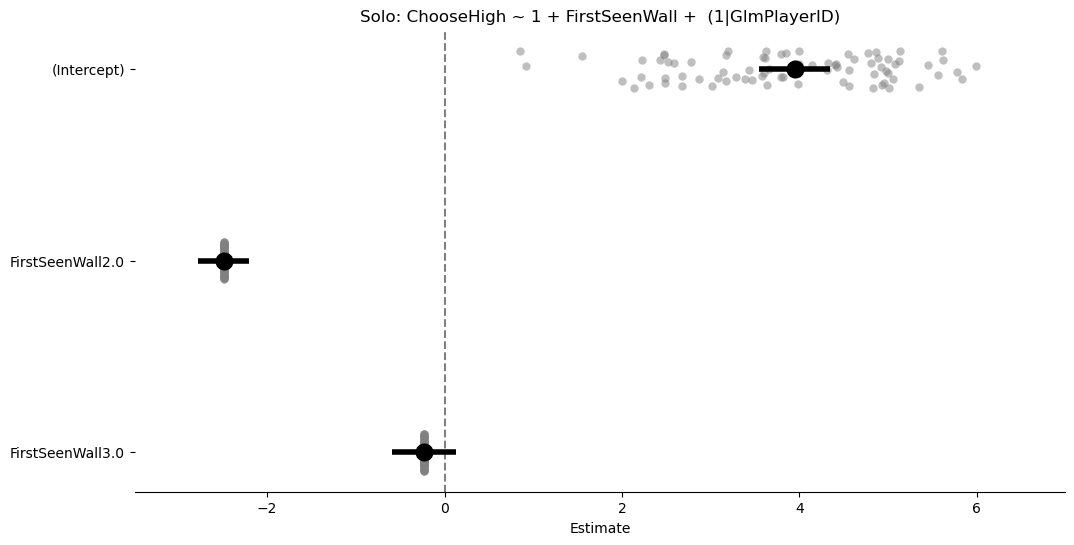

In [13]:
from pymer4.models import Lmer

# define model formula
model_formula = 'ChooseHigh ~ 1 + FirstSeenWall +  (1|GlmPlayerID)'
# model_formula = 'ChooseHigh ~ 1 + D2H + D2L + FirstSeenWall + WallSep + WallSep:FirstSeenWall + (1|GlmPlayerID)'
# model_formula = 'ChooseHigh ~ 1 + D2H + D2L + FirstSeenWall + WallSep + WallSep:FirstSeenWall + D2L:FirstSeenWall + D2H:FirstSeenWall + (1|GlmPlayerID)'


# fit the model
model = Lmer(model_formula, data=glm_df_solo, family='binomial')
results=model.fit(
    control="optimizer='bobyqa', optCtrl=list(maxfun=10000)"
)

# display model results
print(results)
ax = model.plot_summary()
ax.set_title("Solo: " + model_formula)

#### Solo-social combined model

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: ChooseHigh~1+D2H+D2L+FirstSeenWall+WallSep+SocialContext+WallSep:FirstSeenWall+D2H:FirstSeenWall+D2L:FirstSeenWall+SocialContext:FirstSeenWall+SocialContext:D2L+SocialContext:D2H+(1|GlmPlayerID)

Family: binomial	 Inference: parametric

Number of observations: 13990	 Groups: {'GlmPlayerID': 80.0}

Log-likelihood: -4199.654 	 AIC: 8435.309

Random effects:

                    Name    Var    Std
GlmPlayerID  (Intercept)  0.482  0.694

No random effect correlations specified

Fixed effects:

                                Estimate  2.5_ci  97.5_ci     SE      OR  OR_2.5_ci  OR_97.5_ci   Prob  Prob_2.5_ci  Prob_97.5_ci  Z-stat  P-val  Sig
(In

/home/tom/miniconda3/envs/octagon_analysis/lib/python3.12/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


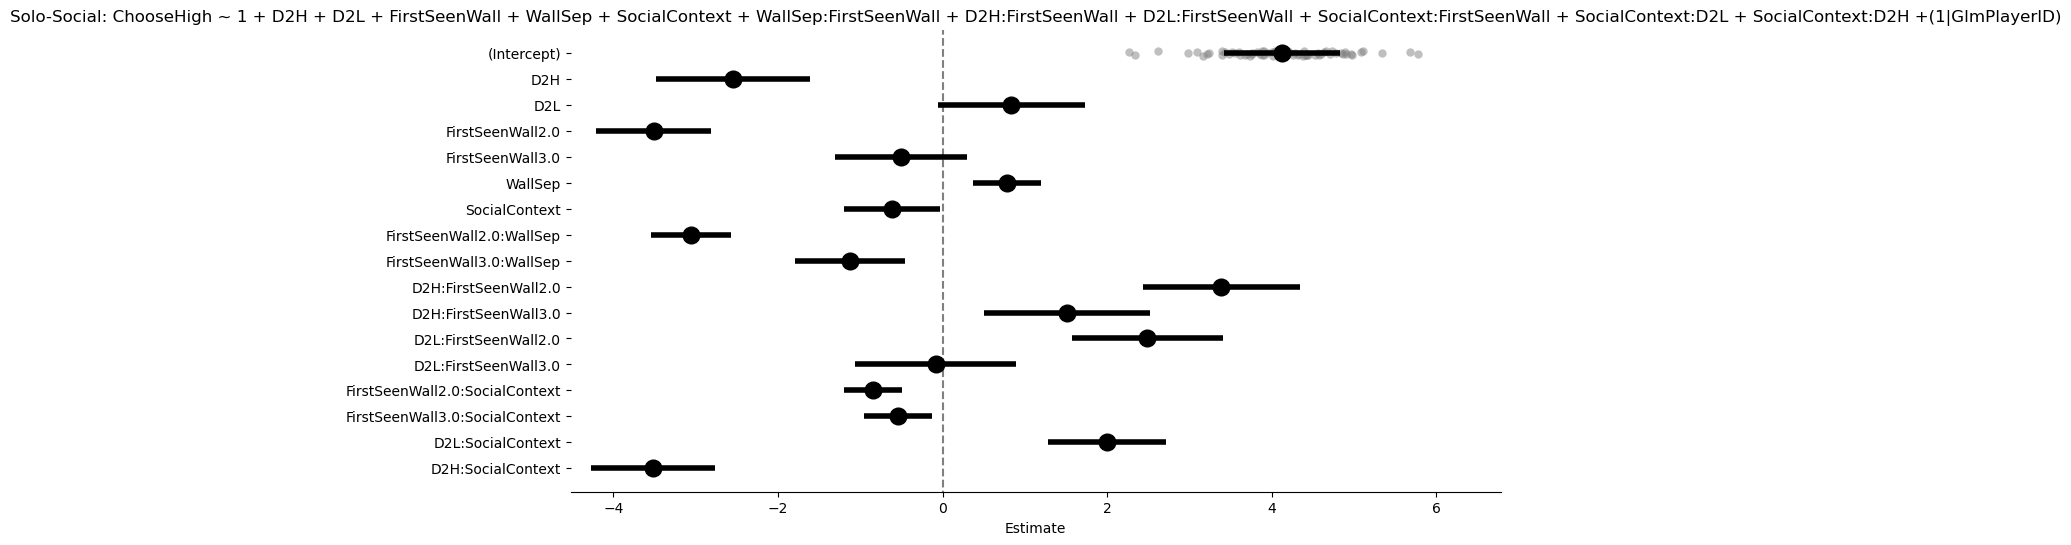

In [24]:
from pymer4.models import Lmer

# model_formula = 'ChooseHigh ~ 1 + D2H + D2L + FirstSeenWall + WallSep + (1 |GlmPlayerID)'
model_formula = 'ChooseHigh ~ 1 + D2H + D2L + FirstSeenWall + WallSep + SocialContext + (1 |GlmPlayerID)'
# model_formula = 'ChooseHigh ~ 1 + D2H + D2L + FirstSeenWall + WallSep + SocialContext + WallSep:FirstSeenWall + D2H:FirstSeenWall + D2L:FirstSeenWall + (1|GlmPlayerID)'
# model_formula = 'ChooseHigh ~ 1 + D2H + D2L + FirstSeenWall + WallSep + SocialContext + SocialContext:D2L + SocialContext:D2H + (1 |GlmPlayerID)'
model_formula = 'ChooseHigh ~ 1 + D2H + D2L + FirstSeenWall + WallSep + SocialContext + SocialContext:D2L + SocialContext:D2H + SocialContext:FirstSeenWall + (1 |GlmPlayerID)'


model_formula = 'ChooseHigh ~ 1 + D2H + D2L + FirstSeenWall + WallSep + SocialContext + WallSep:FirstSeenWall + D2H:FirstSeenWall + D2L:FirstSeenWall + SocialContext:FirstSeenWall + SocialContext:D2L + SocialContext:D2H +(1|GlmPlayerID)'
# solo_random_intercepts_wallsep_wallseen_interaction = Lmer(model_formula, data=glm_df_solo_social, family='binomial')

model = Lmer(model_formula, data=glm_df_solo_social, family='binomial')
results=model.fit(
    control="optimizer='bobyqa', optCtrl=list(maxfun=10000)"
)
ax = model.plot_summary()
ax.set_title("Solo-Social: " + model_formula)

print(results)

#### Social model

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: ChooseHigh~D2H+D2L+FirstSeenWall+WallSep+OpponentD2H+OpponentD2L+OpponentFirstSeenWall+WallSep:FirstSeenWall+D2H:FirstSeenWall+D2L:FirstSeenWall+OpponentD2H:D2H+(1|GlmPlayerID)

Family: binomial	 Inference: parametric

Number of observations: 8446	 Groups: {'GlmPlayerID': 80.0}

Log-likelihood: -1889.896 	 AIC: 3813.793

Random effects:

                    Name    Var    Std
GlmPlayerID  (Intercept)  0.375  0.612

No random effect correlations specified

Fixed effects:

                          Estimate  2.5_ci  97.5_ci     SE      OR  OR_2.5_ci  OR_97.5_ci   Prob  Prob_2.5_ci  Prob_97.5_ci  Z-stat  P-val  Sig
(Intercept)                 

/home/tom/miniconda3/envs/octagon_analysis/lib/python3.12/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


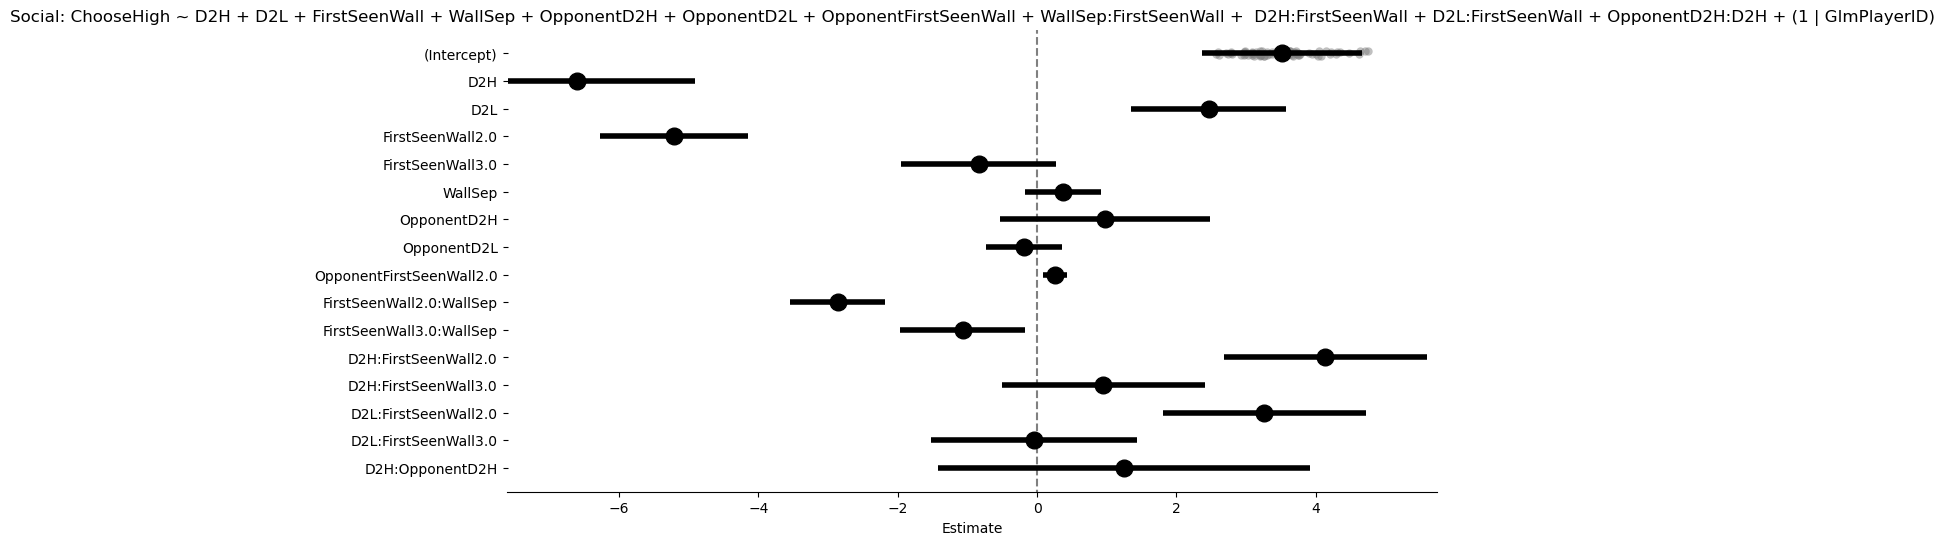

In [27]:
from pymer4.models import Lmer

# model_formula = 'ChooseHigh ~ 1 + D2H + D2L + FirstSeenWall + WallSep + OpponentVisible + OpponentD2H + OpponentD2L + OpponentFirstSeenWall + (1|GlmPlayerID)'
# model_formula = 'ChooseHigh ~ 1 + D2H + D2L + FirstSeenWall + WallSep + OpponentD2H + OpponentD2L + OpponentFirstSeenWall + (1|GlmPlayerID)'

model_formula = 'ChooseHigh ~ D2H + D2L + FirstSeenWall + WallSep + OpponentD2H + OpponentD2L + OpponentFirstSeenWall + WallSep:FirstSeenWall +  (1 | GlmPlayerID)'
model_formula = 'ChooseHigh ~ D2H + D2L + FirstSeenWall + WallSep + OpponentD2H + OpponentD2L + OpponentFirstSeenWall + WallSep:FirstSeenWall +  D2H:FirstSeenWall + D2L:FirstSeenWall + OpponentD2H:D2H + (1 | GlmPlayerID)'

# model_formula = 'ChooseHigh ~ D2H + D2L + FirstSeenWall + WallSep + OpponentVisible + OpponentD2H + OpponentD2L + OpponentFirstSeenWall + (D2H + D2L + FirstSeenWall + WallSep + OpponentVisible + OpponentD2H + OpponentD2L + OpponentFirstSeenWall| GlmPlayerID)'
# model_formula = 'ChooseHigh ~ D2H + D2L + FirstSeenWall + WallSep + OpponentVisible + OpponentD2H + OpponentD2L + (1 + D2H + D2L + FirstSeenWall + OpponentVisible + OpponentD2H + OpponentD2L || GlmPlayerID)'


model = Lmer(model_formula, data=glm_df_social, family='binomial')

results=model.fit(
    control="optimizer='bobyqa', optCtrl=list(maxfun=10000)"
)
ax = model.plot_summary()
ax.set_title("Social: " + model_formula)


print(results)

#### Checking colinearity

In [97]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
import re

model_formula = 'ChooseHigh ~ 1 + D2H + D2L + FirstSeenWall + WallSep + OpponentVisible + OpponentD2H + OpponentD2L + OpponentFirstSeenWall + (1|GlmPlayerID)'

# begin at start (^), lazily match any character any number of times ((.*?)), lazy non-matching group for space, +, space ((?:\s+\s)?), an opening parenthesis (\()
pattern = r'^(.*?)(?:\s\+\s)?\('
match = re.match(pattern, model_formula)
formula = match.group(1)
# formula = 'ChooseHigh ~ D2L + D2H + FirstSeenWall + WallSep + OpponentVisible + OpponentD2H + OpponentD2L + OpponentFirstSeenWall' # only including fixed effects
y, X = dmatrices(formula, data=glm_df_social, return_type='dataframe')

# compute VIF (variance inflation factor)
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range (X.shape[1])]


In [26]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
import re

model_formula = 'ChooseHigh ~ 1 + D2H + D2L + FirstSeenWall + WallSep + (1|GlmPlayerID)'

# begin at start (^), lazily match any character any number of times ((.*?)), lazy non-matching group for space, +, space ((?:\s+\s)?), an opening parenthesis (\()
pattern = r'^(.*?)(?:\s\+\s)?\('
match = re.match(pattern, model_formula)
formula = match.group(1)
# formula = 'ChooseHigh ~ D2L + D2H + FirstSeenWall + WallSep + OpponentVisible + OpponentD2H + OpponentD2L + OpponentFirstSeenWall' # only including fixed effects
y, X = dmatrices(formula, data=glm_df_solo, return_type='dataframe')

# compute VIF (variance inflation factor)
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range (X.shape[1])]


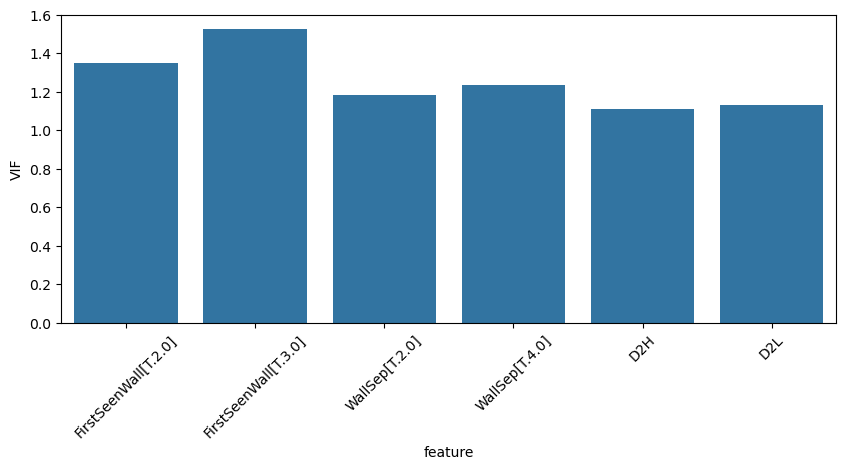

In [27]:
import seaborn as sns

plt.figure(figsize=(10,4))
sns.barplot(data=vif_data, x=vif_data['feature'].iloc[1:], y=vif_data['VIF'].iloc[1:])
plt.tick_params(axis='x', rotation=45)


In [102]:
glm_df_social[['D2L','D2H','FirstSeenWall', 'WallSep', 'OpponentVisible','OpponentD2H', 'OpponentD2L', 'OpponentFirstSeenWall']].corr()

,D2L,D2H,FirstSeenWall,WallSep,OpponentVisible,OpponentD2H,OpponentD2L,OpponentFirstSeenWall
D2L,1.000000000,0.125786195,0.283610294,0.002504460,0.072935137,0.009473124,-0.012471789,-0.017041324
D2H,0.125786195,1.000000000,0.130565134,0.001967019,0.077135199,0.014379237,0.009473124,0.011411470
FirstSeenWall,0.283610294,0.130565134,1.000000000,-0.230161519,0.118595710,0.011411470,-0.017041324,0.056880885
WallSep,0.002504460,0.001967019,-0.230161519,1.000000000,-0.006156287,0.001967019,0.002504460,-0.230161519
OpponentVisible,0.072935137,0.077135199,0.118595710,-0.006156287,1.000000000,-0.000620275,-0.006471035,0.022570096
OpponentD2H,0.009473124,0.014379237,0.011411470,0.001967019,-0.000620275,1.000000000,0.125786195,0.130565134
OpponentD2L,-0.012471789,0.009473124,-0.017041324,0.002504460,-0.006471035,0.125786195,1.000000000,0.283610294
OpponentFirstSeenWall,-0.017041324,0.011411470,0.056880885,-0.230161519,0.022570096,0.130565134,0.283610294,1.000000000


#### Plotting random slopes

In [103]:
model.coefs

,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),2.423293404,1.922786115,2.923800693,0.255365554,11.282957529,6.839988942,18.611891288,0.918586383,0.872448800,0.949010527,9.489507745,2.321278274e-21,***
D2H,-4.036641821,-4.518796567,-3.554487075,0.246001840,0.017656667,0.010902136,0.028596039,0.017350318,0.010784561,0.027801039,-16.408990384,1.649252329e-60,***
D2L,3.252617001,2.778146579,3.727087423,0.242081194,25.857921660,16.089173284,41.557891182,0.962767037,0.941483419,0.976502595,13.436058138,3.717166534e-41,***
FirstSeenWall2.0,-3.115027861,-3.320767148,-2.909288575,0.104970953,0.044377271,0.036125108,0.054514499,0.042491609,0.034865585,0.051696301,-29.675141420,1.607500329e-193,***
FirstSeenWall3.0,-1.109241144,-1.333406298,-0.885075989,0.114372079,0.329809144,0.263577905,0.412682813,0.248012390,0.208596482,0.292127015,-9.698530945,3.058707533e-22,***
WallSep2.0,-0.417862688,-0.594967292,-0.240758084,0.090361152,0.658452636,0.551580607,0.786031757,0.397028303,0.355495940,0.440099541,-4.624362113,3.757529416e-06,***
WallSep4.0,-0.896581196,-1.096089512,-0.697072880,0.101791828,0.407962021,0.334175321,0.498040998,0.289753569,0.250473319,0.332461527,-8.807987999,1.274120729e-18,***
OpponentD2H,1.496061986,1.026229267,1.965894705,0.239714976,4.464074820,2.790523651,7.141299088,0.816986401,0.736184208,0.877169480,6.241003428,4.347727184e-10,***
OpponentD2L,-0.201941114,-0.671361324,0.267479096,0.239504508,0.817143045,0.511012451,1.306666314,0.449685591,0.338192085,0.566473922,-0.843162060,3.991378143e-01,
OpponentFirstSeenWall2.0,0.288361743,0.115001086,0.461722400,0.088450940,1.334239869,1.121874656,1.586804744,0.571595013,0.528718628,0.613422698,3.260132035,1.113603599e-03,**


In [104]:
model.coefs.loc['D2H', 'Estimate']

np.float64(-4.0366418207721475)

In [105]:
model.fixef.iloc[0]

(Intercept)                 2.188905583
D2H                        -4.036641821
D2L                         3.252617001
FirstSeenWall2.0           -3.115027861
FirstSeenWall3.0           -1.109241144
WallSep2.0                 -0.417862688
WallSep4.0                 -0.896581196
OpponentD2H                 1.496061986
OpponentD2L                -0.201941114
OpponentFirstSeenWall2.0    0.288361743
OpponentFirstSeenWall3.0   -0.239951405
Name: 0, dtype: float64

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming ranefs is your wide-format DataFrame
re_df = model.ranef.copy()

# Optional: Add participant IDs as a proper column if they're in the index
re_df['GlmPlayerID'] = re_df.index

# Define slopes to plot and extract fixed effects
slope_vars = ['FirstSeenWall2.0', 'D2H', 'D2L']
fixed_effects_coefs = model.coefs  # Returns a DataFrame with Estimate per predictor


# Plot
fig, axs = plt.subplots(len(slope_vars), 1, figsize=(14,12), sharex=False)
for i, slope in enumerate(slope_vars):
    
    if len(slope_vars) == 1:
        ax = axs
    else:    
        ax = axs[i]

    # Sort by slope for ordered bars
    sorted_df = re_df.sort_values(slope)

    # plot bars
    sns.barplot(data=sorted_df, x='GlmPlayerID', y=slope, ax=ax, palette='coolwarm')
    ax.set_title(f"Random slope values for {slope} across players")
    ax.set_xlabel("Participant ID")
    ax.set_ylabel("Deviation from fixed effect value")

    # Rotate x-axis ticks for readability
    ax.tick_params(axis='x', rotation=90)

    # Annotate with fixed effect value
    fixed_val = fixed_effects_coefs.loc[slope, 'Estimate']
    ax.text(0.01, 0.9, f'Fixed effect = {fixed_val:.3f}', transform=ax.transAxes,
            fontsize=12, bbox=dict(facecolor='white', edgecolor='black'))


plt.tight_layout()
plt.show

In [107]:
model.coefs['Estimate']

(Intercept)                 2.423293404
D2H                        -4.036641821
D2L                         3.252617001
FirstSeenWall2.0           -3.115027861
FirstSeenWall3.0           -1.109241144
WallSep2.0                 -0.417862688
WallSep4.0                 -0.896581196
OpponentD2H                 1.496061986
OpponentD2L                -0.201941114
OpponentFirstSeenWall2.0    0.288361743
OpponentFirstSeenWall3.0   -0.239951405
Name: Estimate, dtype: float64

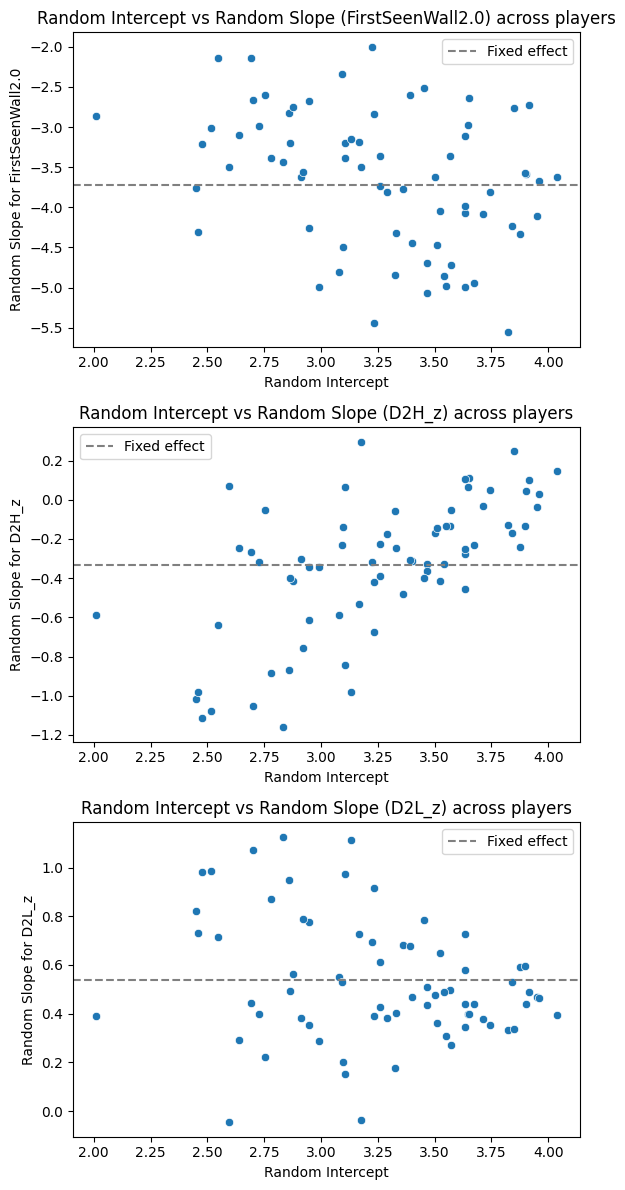

In [ ]:
# Assuming ranefs is your wide-format DataFrame
re_df = model.ranef.copy()
# Optional: Add participant IDs as a proper column if they're in the index
re_df['GlmPlayerID'] = re_df.index

slope_vars = ['FirstSeenWall2.0', 'D2H_z', 'D2L_z']
fixed_effects_coefs = model.coefs  # Returns a DataFrame with Estimate per predictor
fixed_intercept = model.coefs.loc['(Intercept)', 'Estimate']

# plot
fig, axs = plt.subplots(len(slope_vars),1, figsize=(6,12), sharex=False)
for i, slope in enumerate(slope_vars):
    if len(slope_vars) == 1:
        ax = axs
    else:    
        ax = axs[i]

    # sort by slope for ordered bars
    random_slopes = re_df[slope] + fixed_effects_coefs.loc[slope, 'Estimate']
    random_intercepts = re_df['X.Intercept.'] + fixed_intercept

    # Scatter plot
    sns.scatterplot(x=random_intercepts, y=random_slopes, ax=ax)
    ax.set_title(f"Random Intercept vs Random Slope ({slope}) across players")
    ax.set_xlabel("Random Intercept")
    ax.set_ylabel(f"Random Slope for {slope}")

    # Add a horizontal line for the fixed effect
    ax.axhline(fixed_effects_coefs.loc[slope, 'Estimate'], color='gray', linestyle='--', label='Fixed effect')
    ax.legend()



plt.tight_layout()
plt.legend()
plt.show()

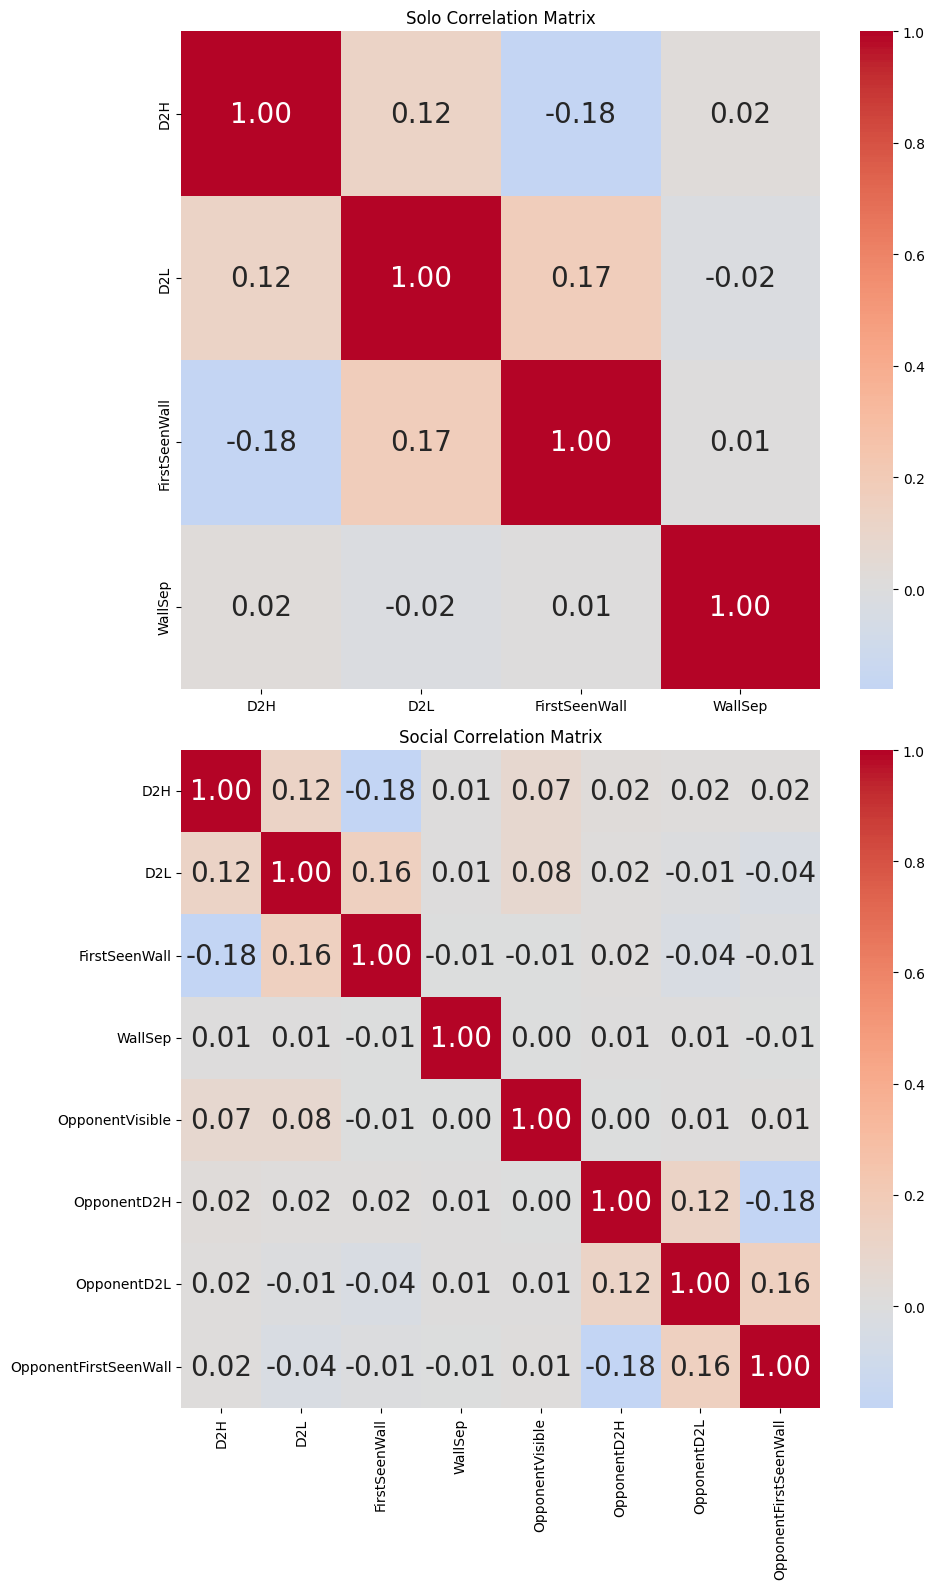

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# predictors
social_predictors = ['D2H', 'D2L', 'FirstSeenWall', 'WallSep', 'OpponentVisible', 'OpponentD2H', 'OpponentD2L', 'OpponentFirstSeenWall']
solo_predictors = ['D2H', 'D2L', 'FirstSeenWall', 'WallSep']

# Compute correlation matrix
corr_matrix_solo = glm_df_solo[solo_predictors].corr()
corr_matrix_social = glm_df_social[social_predictors].corr()

# Plot it
plt.subplots(2,1, figsize=(10, 16))
plt.subplot(2,1,1)
sns.heatmap(corr_matrix_solo, annot=True, fmt=".2f", cmap="coolwarm", center=0, annot_kws={"size": 20})
plt.title("Solo Correlation Matrix")
plt.subplot(2,1,2)
sns.heatmap(corr_matrix_social, annot=True, fmt=".2f", cmap="coolwarm", center=0, annot_kws={"size": 20})
plt.title("Social Correlation Matrix")
plt.tight_layout()
plt.show()

d:\Users\Tom\miniconda3\envs\octagon_analysis\Lib\site-packages\rpy2\robjects\pandas2ri.py:65: UserWarning: Error while trying to convert the column "WallSep". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  warnings.warn('Error while trying to convert '
d:\Users\Tom\miniconda3\envs\octagon_analysis\Lib\site-packages\rpy2\robjects\pandas2ri.py:65: UserWarning: Error while trying to convert the column "FirstSeenWall". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  warnings.warn('Error while trying to convert '
d:\Users\Tom\miniconda3\envs\octagon_analysis\Lib\site-packages\pymer4\models\Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
d:\Users\Tom\miniconda3\envs\octagon_analysis\Lib\site-packages\rpy2\robjects\pandas2ri.py:

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: ChooseHigh~1+D2H+D2L+FirstSeenWall+WallSep+(1|GlmPlayerID)

Family: binomial	 Inference: parametric

Number of observations: 4605	 Groups: {'GlmPlayerID': 70.0}

Log-likelihood: -1144.956 	 AIC: 2305.912

Random effects:

                    Name   Var    Std
GlmPlayerID  (Intercept)  1.95  1.397

No random effect correlations specified

Fixed effects:



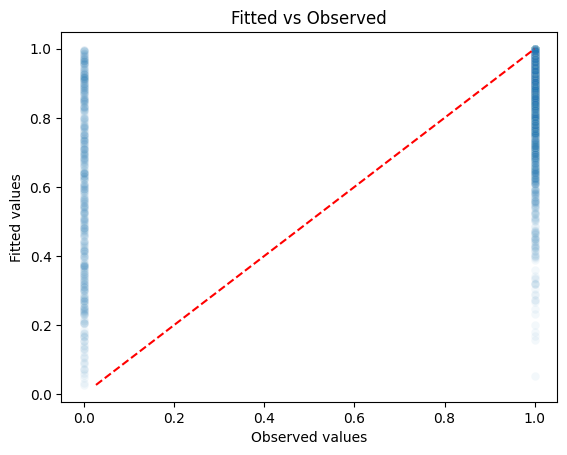

In [159]:
import matplotlib.pyplot as plt
import seaborn as sns

solo_random_intercepts.fit()

# Assuming `model` is your fitted pymer4 model
df = solo_random_intercepts.data.copy()
df = df.dropna() # remove rows with NaN values because these cannot be predicted

df['fitted'] = solo_random_intercepts.predict(df, skip_data_checks=True, verify_predictions=False)

sns.scatterplot(x='ChooseHigh', y='fitted', data=df, alpha=0.05)
plt.plot([df['fitted'].min(), df['fitted'].max()],
         [df['fitted'].min(), df['fitted'].max()], 'r--')
plt.xlabel('Observed values')
plt.ylabel('Fitted values')
plt.title('Fitted vs Observed')
plt.show()

In [ ]:
glm_df_social.to_csv("glm_df_social.csv", index=False)
